In [1]:
!conda install -c rdkit rdkit

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boltons-23.0.0             |     pyhd8ed1ab_0         296 KB  conda-forge
    boost-1.78.0               |   py39h7c9e3ff_4         364 KB  conda-forge
    boost-cpp-1.78.0           |       h75c5d50_1        17.1 MB  conda-forge
    brotli-1.0.9               |       h166bdaf_8          18 KB  conda-forge
    brotli-bin-1.0.9           |       h166bdaf_8          20 KB  conda-forge
    cairo-1.16.0               |    ha61ee94_1014         1.5 MB  conda-forge
    conda-23.3.1               |   py39hf3d152e_0         933 KB  conda-forge
    contourpy-1.0.7            |   py39h4b4f

In [3]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/MyDrive

/content/drive/MyDrive


In [5]:
with open('known_TRPM8-inhibitors.smi') as f:
    smiles_list = [line.rstrip('\n') for line in f]

In [7]:
import time
import random
from pathlib import Path

import pandas as pd
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
compounds = [Chem.MolFromSmiles(smi) for smi in smiles_list]

# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol in compounds]

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))
# NBVAL_CHECK_OUTPUT


Number of compounds converted: 494
Fingerprint length per compound: 2048


In [8]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [9]:
# Example: Calculate single similarity of two fingerprints
# NBVAL_CHECK_OUTPUT
sim = DataStructs.TanimotoSimilarity(fingerprints[0], fingerprints[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.82, distance: 0.18


In [10]:
n = len(fingerprints)

# Calculate number of elements in triangular matrix via n*(n-1)/2
elem_triangular_matr = (n * (n - 1)) / 2
print(
    f"Elements in the triangular matrix ({elem_triangular_matr:.0f}) ==",
    f"tanimoto_distance_matrix(fingerprints) ({len(tanimoto_distance_matrix(fingerprints))})",
)
# NBVAL_CHECK_OUTPUT

Elements in the triangular matrix (121771) == tanimoto_distance_matrix(fingerprints) (121771)


In [11]:
def cluster_fingerprints(fingerprints, cutoff=0.6):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters


In [12]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.6)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)
# NBVAL_CHECK_OUTPUTsmi_unique=np.array(smi_unique)

total # clusters:  21
# clusters with only 1 compound:  3
# clusters with >5 compounds:  11
# clusters with >25 compounds:  4
# clusters with >100 compounds:  1


10 molecules from 1-th largest cluster:


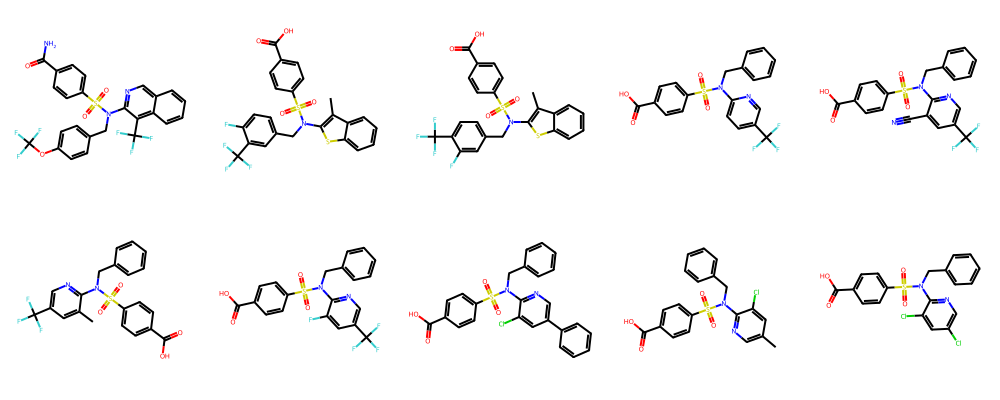

In [13]:
#m molecules from the j-th largest cluster

m=10
j=1

print(str(m)+" molecules from "+ str(j)+"-th largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i] for i in clusters[j-1][:m]],
    molsPerRow=5,
)

In [14]:
#Pick the whole of the first cluster(the largest cluster)

molecules_list=[smiles_list[i] for i in clusters[j-1]]

In [15]:
from collections import defaultdict
from pathlib import Path
from copy import deepcopy
import random

from ipywidgets import interact, fixed, widgets
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools

In [16]:
mols=[Chem.MolFromSmiles(i) for i in molecules_list]

In [17]:
mcs1 = rdFMCS.FindMCS(mols)
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)
# NBVAL_CHECK_OUTPUT

MCS1 contains 17 atoms and 17 bonds.
MCS SMARTS string: [#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#16](=[#8])(=[#8])-[#7](-[#6]-,:[#6]:,-[#6]:,-[#6]:,-[#6])-[#6]:,-[#6]


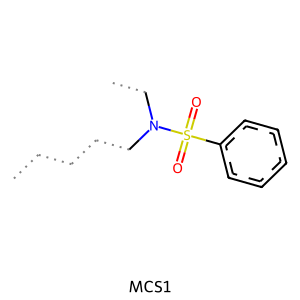

In [18]:
# Draw substructure from Smarts
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

In [19]:
with open('dataset_cleansed.smi') as f:
    smiles_full = [line.rstrip('\n') for line in f]

In [22]:
from rdkit import Chem
from rdkit.Chem import rdFMCS, Draw
from IPython.display import Image
from joblib import Parallel, delayed


other_smiles = smiles_full[0:2000] # Testing only on first 2000 datapoints

other_mols = [Chem.MolFromSmiles(smi) for smi in other_smiles]


# Convert the SMILES string representation of the MCS to a RDKit molecule
mcs_mol = Chem.MolFromSmarts(mcs1.smartsString)

structures=[]
matches=[]
pattern = mcs_mol
for idx,smiles in enumerate(other_smiles):
    m = Chem.MolFromSmiles(smiles)
    structures.append('Structure: '+str(idx+1))
    matches.append(m.HasSubstructMatch(pattern))

match_structures=[]

for i in range(0,len(structures)):
  if matches[i]==True:
    match_structures.append(structures[i])

print(match_structures)

['Structure: 133', 'Structure: 303', 'Structure: 320', 'Structure: 340', 'Structure: 350', 'Structure: 586', 'Structure: 615', 'Structure: 826', 'Structure: 829', 'Structure: 845', 'Structure: 853', 'Structure: 883', 'Structure: 948', 'Structure: 986', 'Structure: 1063', 'Structure: 1081', 'Structure: 1163', 'Structure: 1275', 'Structure: 1408', 'Structure: 1512', 'Structure: 1522', 'Structure: 1780', 'Structure: 1913', 'Structure: 1945', 'Structure: 1981']
